# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from utilsforecast.plotting import plot_series
from datetime import date, timedelta
import calendar
from coreforecast.scalers import boxcox_lambda, boxcox, inv_boxcox
from scipy.stats import entropy

c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão

In [2]:
df_daily_filled = pd.read_csv('../df_daily_filled.csv', parse_dates=['detected'], dtype='int32')
df_daily_filled = df_daily_filled.set_index('detected')
df_daily_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-08-01 to 2024-02-29
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   943 non-null    int32
 1   count_2       943 non-null    int32
 2   direction_3   943 non-null    int32
 3   count_3       943 non-null    int32
 4   direction_4   943 non-null    int32
 5   count_4       943 non-null    int32
 6   direction_5   943 non-null    int32
 7   count_5       943 non-null    int32
 8   direction_6   943 non-null    int32
 9   count_6       943 non-null    int32
 10  direction_7   943 non-null    int32
 11  count_7       943 non-null    int32
 12  direction_8   943 non-null    int32
 13  count_8       943 non-null    int32
 14  direction_9   943 non-null    int32
 15  count_9       943 non-null    int32
 16  direction_10  943 non-null    int32
 17  count_10      943 non-null    int32
 18  direction_11  943 non-null    int32
 19  count_11  

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df_daily_filled.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

            direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117

In [4]:
#sem variavel exogena
df_daily_filled = df_daily_filled.resample('D').sum()
df_8 = df_daily_filled.filter(['count_8']).reset_index().assign(unique_id = 8)
df_8 = df_8.filter(['unique_id','detected','count_8'])
df_8.columns = ['unique_id','ds','y']
df_8

,unique_id,ds,y
0,8,2021-08-01,106
1,8,2021-08-02,91
2,8,2021-08-03,115
3,8,2021-08-04,104
4,8,2021-08-05,107
...,...,...,...
938,8,2024-02-25,75
939,8,2024-02-26,112
940,8,2024-02-27,137
941,8,2024-02-28,156


In [5]:
def calcular_pascoa(ano):
    """Calcula a data da Páscoa para um dado ano (algoritmo de Meeus/Jones/Butcher)."""
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

#feriados 
def calcular_feriados_portugal(anos, incluir_lisboa=False):
    feriados = []

    for ano in anos:
        # Feriados
        feriados += [
            date(ano, 1, 1),   # Ano Novo
            date(ano, 4, 25),  # Dia da Liberdade
            date(ano, 5, 1),   # Dia do Trabalhador
            date(ano, 6, 10),  # Dia de Portugal
            date(ano, 8, 15),  # Assunção de Nossa Senhora
            date(ano, 10, 5),  # Implantação da República
            date(ano, 11, 1),  # Dia de Todos os Santos
            date(ano, 12, 1),  # Restauração da Independência
            date(ano, 12, 8),  # Imaculada Conceição
            date(ano, 12, 25), # Natal
            date(ano, 6, 13),  # Santo António
        ]

        # Feriados Domingo de Páscoa
        pascoa = calcular_pascoa(ano)
        feriados += [
            pascoa - timedelta(days=47), # Carnaval
            pascoa - timedelta(days=2),  # Sexta-feira Santa
            pascoa + timedelta(days=1),  # Segunda-feira de Páscoa 
            pascoa + timedelta(days=60), # Corpo de Deus
        ]

    return set(feriados)


In [6]:
anos = df_daily_filled.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_daily_filled['holiday'] = df_daily_filled.index.date
df_daily_filled['holiday'] = df_daily_filled['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)


In [7]:
#fim de semana
df_daily_filled['weekend'] = df_daily_filled.index.weekday.isin([5, 6]).astype(int)
df_daily_filled['exog'] = ((df_daily_filled['holiday'] == 1) | (df_daily_filled['weekend'] == 1)).astype(int)


In [8]:
#com variavel exogena 
df_8_1 = df_daily_filled[['count_8', 'exog']].reset_index().assign(unique_id=8)
df_8_1.columns = ['ds', 'y', 'X', 'unique_id']
df_8_1 = df_8_1[['unique_id', 'ds', 'y', 'X']].query('ds < "2022-08-01"')
df_8_1

,unique_id,ds,y,X
0,8,2021-08-01,106,1
1,8,2021-08-02,91,0
2,8,2021-08-03,115,0
3,8,2021-08-04,104,0
4,8,2021-08-05,107,0
...,...,...,...,...
360,8,2022-07-27,131,0
361,8,2022-07-28,115,0
362,8,2022-07-29,99,0
363,8,2022-07-30,75,1


# MSTL forecast

In [9]:
#model = AutoARIMA(season_length=7)
model = MSTL(season_length=[7], trend_forecaster=AutoARIMA())

sf = StatsForecast(
    models=[model],
    freq='D',
    n_jobs=-1
)

sf.fit(df_8_1)

# Criar o DataFrame de previsão para o próximo dia
future_dates = pd.date_range(start='2024-03-01', periods=1, freq='D')
future_exog = pd.DataFrame({
    'ds': future_dates,
    'X': [0]  
})
future_exog['unique_id'] = 8  

# Realizar a previsão
levels=[99.7]
fcst = sf.forecast(df=df_8_1, X_df=future_exog, h=1, level=levels, fitted=True)

# Exibir as previsões
print(fcst)


   unique_id         ds        MSTL  MSTL-lo-99.7  MSTL-hi-99.7
0          8 2022-08-01  118.129478     49.413067    186.845886


In [10]:
# models = [MSTL(season_length = [7])]
# sf = StatsForecast(
#     models=models, 
#     freq='D',
#     n_jobs=-1,
# )

# horizon = 7
# levels = [99] 

# fcst = sf.forecast(df=df_8_1, h=7, level=[99], fitted=True)
# fcst.head()

In [11]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()


,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
0,8,2021-08-01,106.0,97.394295,28.677883,166.110703
1,8,2021-08-02,91.0,98.473061,29.756651,167.189468
2,8,2021-08-03,115.0,95.154320,26.437908,163.870728
3,8,2021-08-04,104.0,108.334389,39.617977,177.050797
4,8,2021-08-05,107.0,99.840744,31.124329,168.557159


In [12]:
# anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
# anomalies
anomalies = insample_forecasts[
    ~insample_forecasts['y'].between(
        insample_forecasts.iloc[:,4],
        insample_forecasts.iloc[:,5]
    )
]

anomalies

,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
146,8,2021-12-25,276.0,91.666786,22.950373,160.383194
147,8,2021-12-26,389.0,228.984833,160.268417,297.701233
148,8,2021-12-27,50.0,174.463547,105.747131,243.179962


In [13]:
plot_series(forecasts_df=insample_forecasts, level=levels, plot_anomalies=True, engine='plotly')

# Função dinamica

In [14]:
def fill_zeros(df_daily_filled, max_weeks_back=5):
    df_filled = df_daily_filled.copy()
    for col in df_daily_filled.columns:
        if col.startswith('count_'):
            zero_dates = df_daily_filled[df_daily_filled[col] == 0].index
            for datetime in zero_dates:
                for weeks_back in range(1, max_weeks_back + 1):
                    prev_week = datetime - pd.Timedelta(weeks=weeks_back)
                    if prev_week in df_daily_filled.index:
                        prev_value = df_daily_filled.loc[prev_week, col]
                        if prev_value != 0:
                            df_filled.loc[datetime, col] = prev_value
                            break
    return df_filled


In [15]:
def aplica_algoritmo(df_daily_filled, contador_id, exog_col='exog',
                     start_date='2021-08-01', end_date='2022-08-01',
                     season_length=[7], n_jobs=-1, datas_corrigidas_previamente=None):
    
    if contador_id is None:
        raise ValueError("É necessário especificar o 'contador_id'.")
    
    if contador_id not in df_daily_filled.columns:
        raise ValueError(f"Contador {contador_id} não encontrado no DataFrame.")
    
    if exog_col not in df_daily_filled.columns:
        raise ValueError(f"Coluna exógena {exog_col} não encontrada no DataFrame.")
    
    if datas_corrigidas_previamente is None:
        datas_corrigidas_previamente = set()
    
    # 1. Filtrar dados históricos até à data limite
    df_hist = df_daily_filled.loc[start_date:end_date].copy()
    df_hist[contador_id] = df_hist[contador_id].astype(float)

    # 2. Substituir dias com zeros 
    df_hist_corr = fill_zeros(df_hist)
    

    # 3. Preparar dados para StatsForecast
    unique_id = contador_id
    df_model = df_hist_corr[[contador_id, exog_col]].reset_index().assign(unique_id=unique_id)
    df_model.columns = ['ds', 'y', 'X', 'unique_id']
    df_model = df_model[['unique_id', 'ds', 'y', 'X']]

    # 4. Ajustar o modelo
    model = MSTL(season_length=season_length, trend_forecaster=AutoARIMA())
    sf = StatsForecast(models=[model], freq='D', n_jobs=n_jobs)
    sf.fit(df_model)
    
    
    # 5. Previsão (1 dia à frente apenas, para completar fitting)
    future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=1, freq='D')
    future_exog_values = [1 if d.date() in feriados else 0 for d in future_dates]

    future_exog = pd.DataFrame({
        'ds': future_dates,
        'X': future_exog_values,
        'unique_id': [contador_id] * len(future_dates)      
    })

    levels=[99.7]
    sf.forecast(df=df_model, X_df=future_exog, h=1, level=levels, fitted=True)

    # 6. Obter previsões in-sample e identificar outliers
    insample_fcst = sf.forecast_fitted_values()
    insample_fcst.columns = ['unique_id', 'ds', 'y', 'fitted', 'lo_99_7', 'hi_99_7']

    anomalies = insample_fcst[
        ~insample_fcst['y'].between(insample_fcst['lo_99_7'], insample_fcst['hi_99_7'])
    ].copy()

    novas_datas_corrigidas = set()

    # 7. Corrigir anomalias
    for _, row in anomalies.iterrows():
        dia = row['ds']
        
        if dia in datas_corrigidas_previamente or dia in novas_datas_corrigidas:
            continue

        y = row['y']
        hi = row['hi_99_7']
        lo = row['lo_99_7']
        historico = df_hist_corr.loc[df_hist_corr.index < dia, contador_id]

        if historico.empty:
            continue

        max_hist = historico.max()

        if y > hi:
            novo_valor = min(hi, max_hist)
        elif y < lo:
            novo_valor = lo
        else:
            continue

        df_hist_corr.loc[dia, contador_id] = novo_valor
        novas_datas_corrigidas.add(dia)


    # 9. Retornar histórico corrigido, anomalias, datas corrigidas e componente semanal
    return df_hist_corr, anomalies, novas_datas_corrigidas



In [16]:
#para um periodo de 2 semanas no maximo: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added, max_weeks=2):
#     if weeks_added >= max_weeks:
#         return df_hist, weeks_added, False

#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)
#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True


# para todos os dados: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added):
#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)

#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True



# Rolling windows (janela deslizante), avança de uma semana e elimina uma semana do inicio
def get_one_more_week_rolling(df_daily_filled, df_hist, weeks_added, janela_semanas=52):
    last_date = df_hist.index.max()
    next_week_start = last_date + pd.Timedelta(days=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

    if df_next_week.empty:
        return df_hist, weeks_added, False

    # Concatenar nova semana
    df_hist_updated = pd.concat([df_hist, df_next_week])

    # Manter janela de tamanho fixo (em semanas)
    dias_janela = janela_semanas * 7
    min_date = df_hist_updated.index.max() - pd.Timedelta(days=dias_janela - 1)
    df_hist_updated = df_hist_updated[df_hist_updated.index >= min_date]

    return df_hist_updated, weeks_added + 1, True


In [17]:
# # Dicionários para guardar resultados de cada contador <- para todos os contadores
# resultados_corrigidos_por_contador = {}
# anomalias_por_contador = {}

resultados_corrigidos = [] # <- quando for para todos os contadores esta linha e as 2 proximas não são necessarias
todas_anomalias = []
datas_corrigidas_global = set()

contador_id = 'count_8' # <- quando for para todos os contadores tem de ser eliminada
exog_col = 'exog'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
#max_semanas = 2
semanas_adicionadas = 0 #quando for para todos os contadores tem de ser eliminada

# for contador_id in colunas_contadores:  <- par todos os contadores
#     if not contador_id.startswith("count_"):
#         continue  # ignora colunas que não são contadores

#     print(f"\n### PROCESSANDO {contador_id} ###")

#     resultados_corrigidos = []
#     todas_anomalias = []
#     datas_corrigidas_global = set()
#     semanas_adicionadas = 0

    # Aplicar primeira vez
df_hist_atual, anomalies_iniciais, datas_corrigidas = aplica_algoritmo(
    df_daily_filled=df_daily_filled,
    contador_id=contador_id,
    exog_col=exog_col,
    start_date=start_date,
    end_date=end_date_inicial,
    datas_corrigidas_previamente=datas_corrigidas_global
)

    # Atualizar listas
datas_corrigidas_global.update(datas_corrigidas)
resultados_corrigidos.append(df_hist_atual.copy())
todas_anomalias.append(anomalies_iniciais)

    # Loop
while True:    
#while semanas_adicionadas < max_semanas:
    df_hist_atual, semanas_adicionadas, conseguiu_adicionar = get_one_more_week_rolling(
        df_daily_filled=df_daily_filled,
        df_hist=df_hist_atual,
        weeks_added=semanas_adicionadas,
        #max_weeks=max_semanas
        janela_semanas=52  # ou outro valor
    )

    if not conseguiu_adicionar:
        print("Não há mais semanas para adicionar.")
        break

    df_corrigido, novas_anomalias, novas_datas_corrigidas = aplica_algoritmo(
        df_daily_filled=df_hist_atual,
        contador_id=contador_id,
        exog_col=exog_col,
        start_date=start_date,
        end_date=df_hist_atual.index.max().strftime('%Y-%m-%d'),
        datas_corrigidas_previamente=datas_corrigidas_global
    )

    # Filtrar anomalias para ignorar as que já foram corrigidas antes
    novas_anomalias = novas_anomalias[~novas_anomalias['ds'].isin(datas_corrigidas_global)].copy()

    # Atualizar conjunto global das datas corrigidas
    datas_corrigidas_global.update(novas_datas_corrigidas)

    df_hist_atual = df_corrigido.copy()
    resultados_corrigidos.append(df_hist_atual.copy())
    todas_anomalias.append(novas_anomalias)

    print(f"Semana {semanas_adicionadas} processada com {len(novas_anomalias)} novos outliers.")


    # # Guardar resultados <- para todos os contadores
    # resultados_corrigidos_por_contador[contador_id] = resultados_corrigidos
    # anomalias_por_contador[contador_id] = pd.concat(todas_anomalias, ignore_index=True)

Semana 1 processada com 1 novos outliers.
Semana 2 processada com 1 novos outliers.
Semana 3 processada com 0 novos outliers.
Semana 4 processada com 0 novos outliers.
Semana 5 processada com 0 novos outliers.
Semana 6 processada com 0 novos outliers.
Semana 7 processada com 1 novos outliers.
Semana 8 processada com 0 novos outliers.
Semana 9 processada com 0 novos outliers.
Semana 10 processada com 0 novos outliers.
Semana 11 processada com 1 novos outliers.
Semana 12 processada com 1 novos outliers.
Semana 13 processada com 1 novos outliers.
Semana 14 processada com 0 novos outliers.
Semana 15 processada com 0 novos outliers.
Semana 16 processada com 0 novos outliers.
Semana 17 processada com 0 novos outliers.
Semana 18 processada com 0 novos outliers.
Semana 19 processada com 1 novos outliers.
Semana 20 processada com 0 novos outliers.
Semana 21 processada com 0 novos outliers.
Semana 22 processada com 1 novos outliers.
Semana 23 processada com 0 novos outliers.
Semana 24 processada

In [18]:
#Juntar todas as anomalias detetadas 
anomalias_totais = pd.concat(todas_anomalias)
anomalias_totais

# Para todos os contadores
# anomalias_totais = pd.concat(
#     [df.assign(contador=contador_id) for contador_id, df in anomalias_por_contador.items() if not df.empty],
#     ignore_index=True
# )

# if anomalias_totais.empty:
#     print("Nenhuma anomalia encontrada.")
# else:
#     print(anomalias_totais[['ds', 'contador', 'y', 'lo_99_7', 'hi_99_7']])



,unique_id,ds,y,fitted,lo_99_7,hi_99_7
146,count_8,2021-12-25,276.0,91.666785,22.950374,160.383197
147,count_8,2021-12-26,389.0,228.984836,160.268424,297.701248
148,count_8,2021-12-27,50.0,174.463543,105.747131,243.179955
87,count_8,2021-11-04,177.0,109.819141,56.880014,162.758267
357,count_8,2022-08-08,14.0,119.927474,64.477089,175.377859
358,count_8,2022-09-13,233.0,164.812446,108.727536,220.897356
357,count_8,2022-10-10,84.0,142.506784,85.557143,199.456425
359,count_8,2022-10-19,90.0,147.520689,90.363700,204.677677
358,count_8,2022-10-25,281.0,187.569480,128.324823,246.814137
8,count_8,2021-12-21,39.0,98.193451,39.097650,157.289252


In [19]:
df_corrigido_final = pd.concat(resultados_corrigidos)
df_corrigido_final = df_corrigido_final[~df_corrigido_final.index.duplicated(keep='last')]

fig = px.line(
    df_corrigido_final, 
    y=contador_id, 
    title=f"Contagem corrigida – {contador_id}",
    labels={"index": "Data", contador_id: "Contagem"},
)

fig.update_layout(width=1900, height=350)
fig.show()


# Se eu quiser fazer para todos os contadores

# for contador_id, lista_resultados in resultados_corrigidos_por_contador.items():
#     if not lista_resultados:
#         continue  # pular se a lista estiver vazia

#     df_corrigido_final = lista_resultados[-1]  # último resultado corrigido

#     fig = px.line(
#         df_corrigido_final,
#         y=contador_id,
#         title=f"Contagem corrigida - {contador_id}",
#         labels={"index": "Data", contador_id: "Contagem"}
#     )
#     fig.update_layout(width=1300, height=350)
#     fig.show()



# Métodos basicos 

### Seasonality ratio (SR) e Seasonality Indicator (SI)

In [ ]:
def calcular_sr_si(df, coluna='count_8', plotar=True):
    df = df.copy()
    df.columns = ['datetime', coluna]
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extrair ano e semana ISO
    df['ano'] = df['datetime'].dt.isocalendar().year
    df['semana'] = df['datetime'].dt.isocalendar().week

    # 1) SR agregado por semana (todos os anos juntos)
    df_sr_semana = df.groupby('semana')[coluna].agg(['mean', 'max']).reset_index()
    df_sr_semana.rename(columns={'mean': 'media_semanal', 'max': 'max_semanal'}, inplace=True)
    df_sr_semana['SR'] = df_sr_semana['max_semanal'] / df_sr_semana['media_semanal']


    # 2) SR separado por ano e semana
    df_sr_ano_semana = df.groupby(['ano', 'semana'])[coluna].agg(['mean', 'max']).reset_index()
    df_sr_ano_semana.rename(columns={'mean': 'media_semanal', 'max': 'max_semanal'}, inplace=True)
    df_sr_ano_semana['SR'] = df_sr_ano_semana['max_semanal'] / df_sr_ano_semana['media_semanal']

    resultados_si = []
    for ano, grupo in df_sr_ano_semana.groupby('ano'):
        media_sr = grupo['SR'].mean()
        max_sr = grupo['SR'].max()
        si = media_sr / max_sr if max_sr != 0 else None
        resultados_si.append({
            'ano': ano,
            'SI': round(si, 4) if si is not None else None,
            'SR_medio': round(media_sr, 4),
            'SR_max': round(max_sr, 4)
        })

    df_si = pd.DataFrame(resultados_si).sort_values('ano').reset_index(drop=True)

    if plotar:
        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        for ano in sorted(df_sr_ano_semana['ano'].unique()):
            subset = df_sr_ano_semana[df_sr_ano_semana['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['SR'], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.xlim(1, 53)
        plt.title('Seasonality Ratio (SR) por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(df_sr_semana['semana'], df_sr_semana['SR'], marker='o', color='black')
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.title('Seasonality Ratio (SR) semanal (máximo/média)')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(df_si['ano'], df_si['SI'], marker='o', color='green', label='Seasonality Indicator (SI)')
        plt.axhline(1, color='red', linestyle='--', label='SI = 1 (sem sazonalidade)')
        plt.title('Seasonality Indicator (SI) por Ano')
        plt.xlabel('Ano')
        plt.ylabel('SI')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_sr_ano_semana, df_sr_semana, df_si

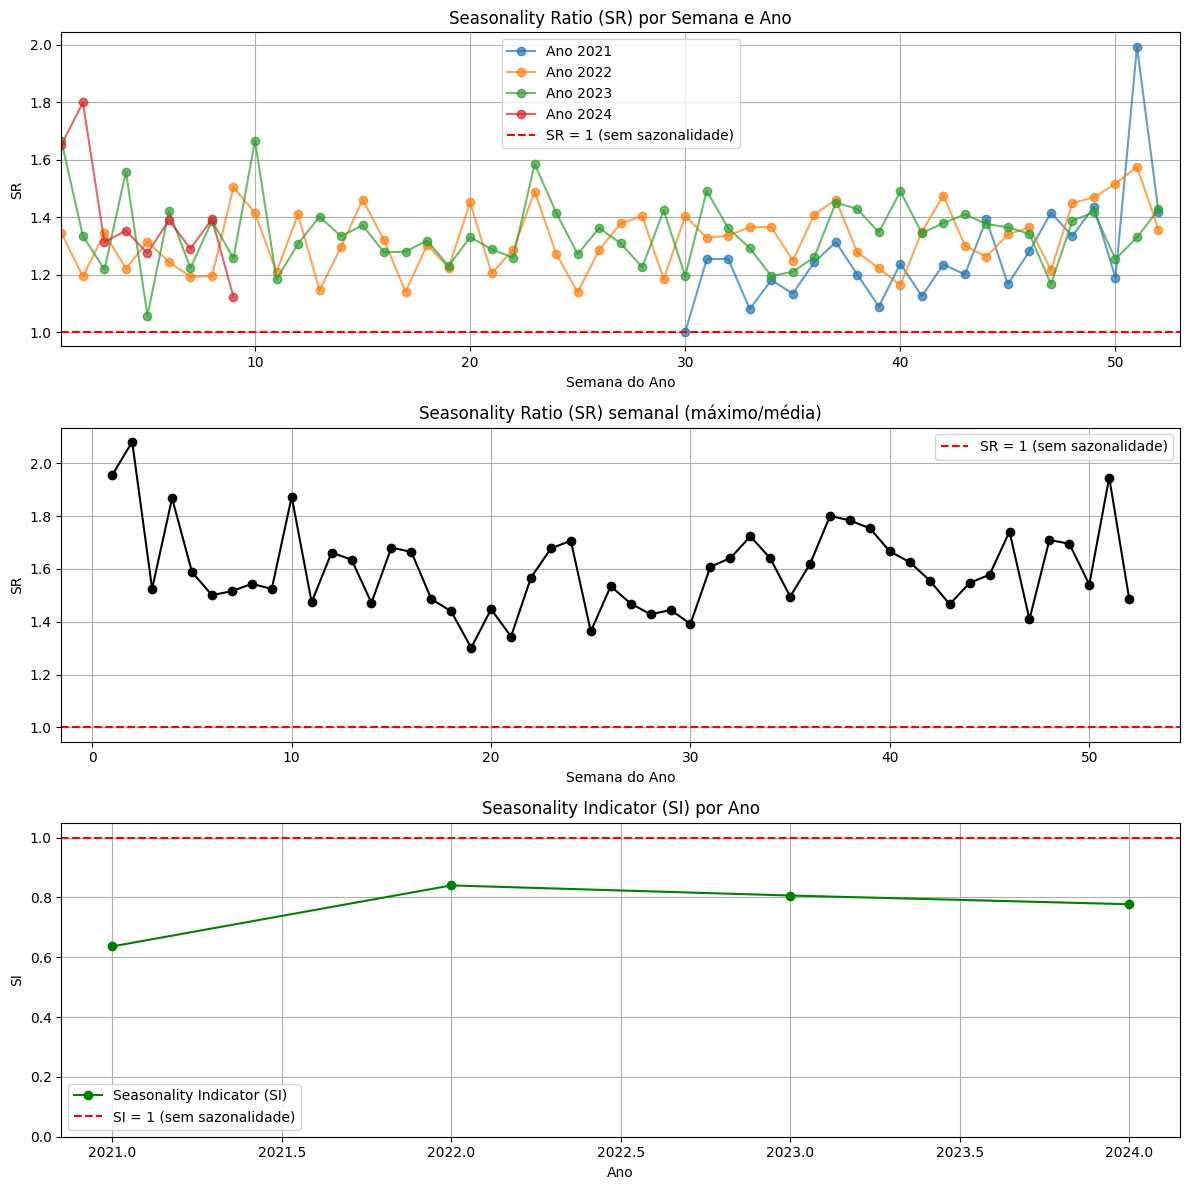

      ano  semana  media_semanal  max_semanal        SR
0    2021      30     106.000000        106.0  1.000000
1    2021      31      91.714286        115.0  1.253894
2    2021      32      70.142857         88.0  1.254582
3    2021      33      75.000000         81.0  1.080000
4    2021      34      81.285714         96.0  1.181019
..    ...     ...            ...          ...       ...
131  2024       5     138.857143        177.0  1.274691
132  2024       6     105.815393        147.0  1.389212
133  2024       7     125.571429        162.0  1.290102
134  2024       8     121.285714        169.0  1.393404
135  2024       9     139.000000        156.0  1.122302

[136 rows x 5 columns]
 
    semana  media_semanal  max_semanal        SR
0        1      95.253183   186.316836  1.956017
1        2     108.660443   226.256070  2.082230
2        3      97.714286   149.000000  1.524854
3        4     104.904762   196.000000  1.868361
4        5     111.428571   177.000000  1.588462
5       

In [21]:

df_diario = df_corrigido_final['count_8'].reset_index()
df_diario.columns = ['datetime', 'count_8']
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_diario, coluna='count_8', plotar=True)

print(df_sr_ano_semana)
print(' ')        
print(df_sr_semana)    
print(' ')  
print(df_si)                    


### Com a decomposição STL

In [22]:
y = df_corrigido_final['count_8']
y_boxcox = boxcox(y, lmbda=0)
best_lambda = boxcox_lambda(y, method='guerrero', season_length=7)
y_boxcox = boxcox(y, best_lambda)

In [23]:
inv_boxcox(y_boxcox, best_lambda).round(0)

array([106.,  91., 115., 104., 107.,  77.,  71.,  77.,  88.,  67.,  69.,
        77.,  62.,  59.,  69.,  78.,  77.,  77.,  81.,  64.,  68.,  80.,
        74.,  92.,  78.,  88.,  87.,  54.,  96.,  93.,  99.,  85.,  75.,
        85.,  78.,  96.,  93.,  72.,  92.,  84., 104., 106., 119.,  56.,
        63.,  93., 106.,  68.,  95.,  84.,  94., 105., 113.,  87.,  75.,
        87.,  98.,  99.,  88., 101.,  87., 103.,  89.,  95.,  95., 101.,
       127.,  93., 111.,  98.,  93., 123., 110., 132., 131., 124., 100.,
       101., 134., 138.,  90.,  72., 123., 116., 109., 102., 141., 139.,
       133., 113.,  69., 125.,  96.,  89.,  88., 141., 119.,  71., 105.,
       118., 134., 135., 124., 116.,  68., 115., 128., 125.,  93., 109.,
       103.,  55.,  86.,  97., 110., 132.,  77., 112.,  57.,  68.,  89.,
       114.,  59.,  97., 111.,  52.,  76.,  99.,  80.,  54.,  72.,  64.,
        84., 117.,  93., 116., 123., 117., 110.,  72.,  93., 113.,  39.,
        51.,  47.,  34., 160., 177., 106.,  67.,  6

In [24]:
stl = STL(y_boxcox, period=7)
decomp_stl = stl.fit()
df_decomp_stl = pd.DataFrame({
    'observed': inv_boxcox(decomp_stl.observed, best_lambda),
    'trend': inv_boxcox(decomp_stl.trend, best_lambda),
    'seasonal': inv_boxcox(decomp_stl.seasonal, best_lambda),
    'residual': inv_boxcox(decomp_stl.resid, best_lambda)
}, index=df_corrigido_final.index)

df_decomp_stl.head(15)

,observed,trend,seasonal,residual
detected,,,,
2021-08-01,106.000168,108.003988,0.999500,1.000212
2021-08-02,91.000214,102.713977,1.000253,0.997709
2021-08-03,115.000008,97.815446,1.001012,1.001506
2021-08-04,104.000168,93.293179,1.001222,1.000582
2021-08-05,107.000084,89.126421,1.003456,0.999613
2021-08-06,76.999878,85.291393,0.997168,1.000820
2021-08-07,70.999977,81.773340,0.996818,1.000243
2021-08-08,76.999878,78.444116,1.000004,0.999615
2021-08-09,87.999878,75.468710,1.000668,1.002358


,observed,trend,seasonal,residual,seasonadjust
detected,,,,,
2021-08-01,106.000168,108.003988,0.999500,1.000212,0.981447
2021-08-02,91.000214,102.713977,1.000253,0.997709,0.885957
2021-08-03,115.000008,97.815446,1.001012,1.001506,1.175684
2021-08-04,104.000168,93.293179,1.001222,1.000582,1.114767
2021-08-05,107.000084,89.126421,1.003456,0.999613,1.200543
...,...,...,...,...,...
2024-02-25,75.000328,110.879568,0.991905,1.001177,0.676413
2024-02-26,112.000572,109.623797,1.001155,0.999167,1.021681
2024-02-27,136.999756,108.594895,1.002685,1.000511,1.261567


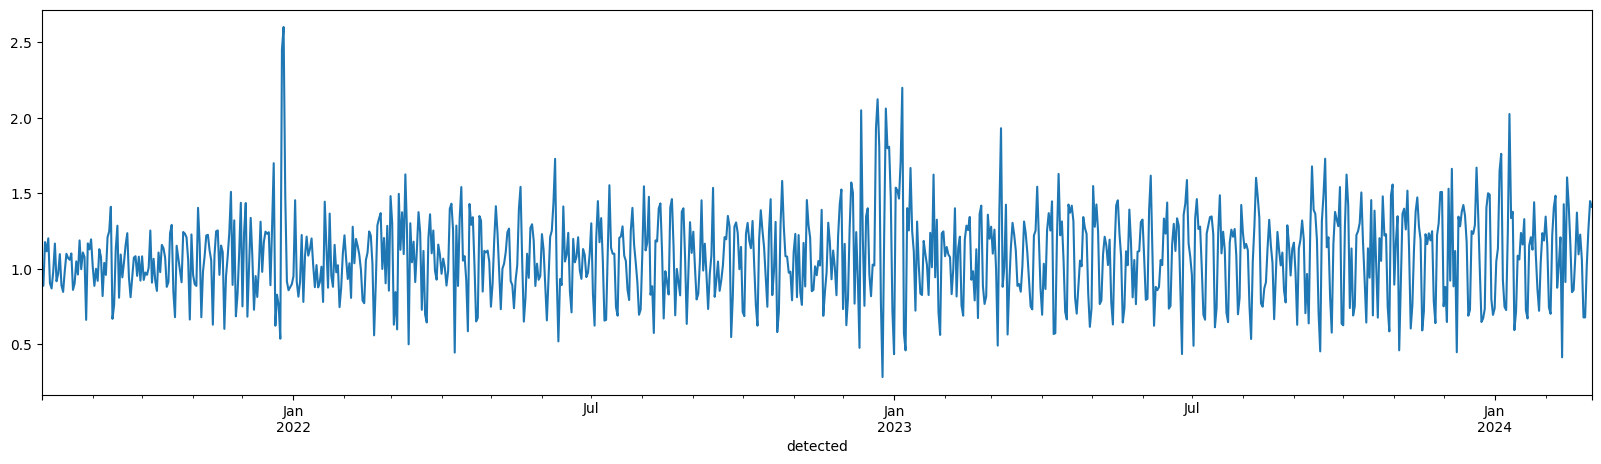

In [25]:
df_season_stl = df_decomp_stl.assign(seasonadjust = df_decomp_stl.observed / df_decomp_stl.trend)
df_season_stl.seasonadjust.plot(figsize=(20,5));
df_season_stl

In [ ]:
df_sem_tendencia = pd.DataFrame({
    'datetime': df_decomp_stl.index,
    'count_8': df_season_stl['seasonadjust']
})

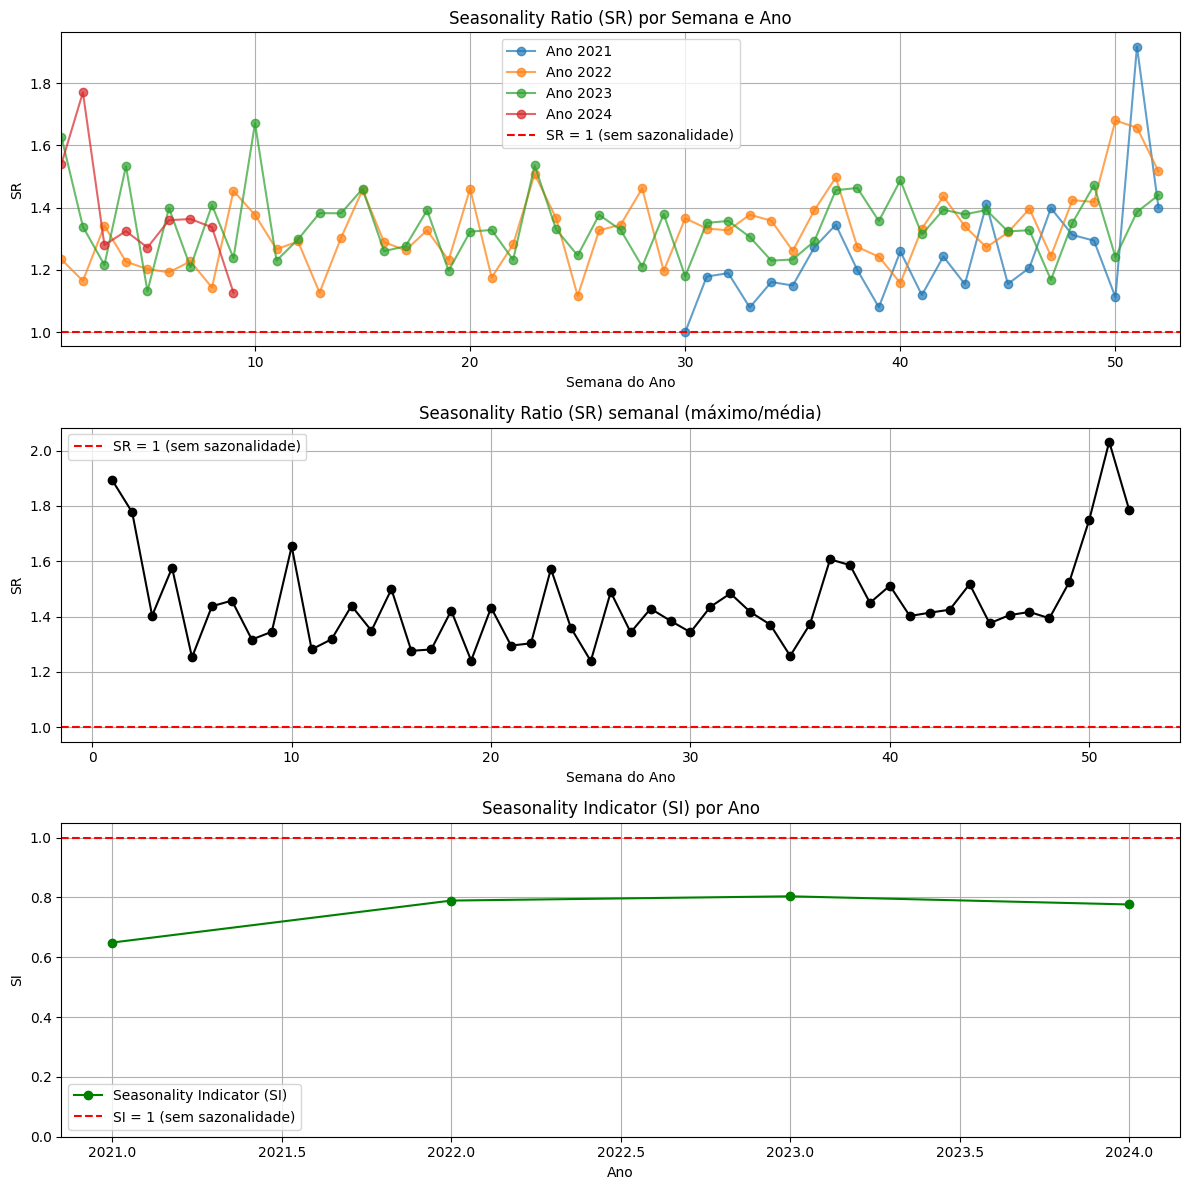

In [ ]:
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_sem_tendencia, coluna='count_8', plotar=True)

In [28]:
df_sem_tendencia

,datetime,count_8
detected,,
2021-08-01,2021-08-01,0.981447
2021-08-02,2021-08-02,0.885957
2021-08-03,2021-08-03,1.175684
2021-08-04,2021-08-04,1.114767
2021-08-05,2021-08-05,1.200543
...,...,...
2024-02-25,2024-02-25,0.676413
2024-02-26,2024-02-26,1.021681
2024-02-27,2024-02-27,1.261567


### Indice de Gini

In [29]:
def gini_geometrico(valores):
    x = np.sort(np.array(valores))
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return np.nan
    y_acumulado = np.cumsum(x) / np.sum(x)
    x_lin = np.arange(1, n + 1) / n
    return (2 / n) * np.sum(x_lin - y_acumulado)


In [30]:
def gini_semanal(df, coluna='count_8', plotar=True):
    # Extrair ano e semana ISO
    df['ano'] = df['datetime'].dt.isocalendar().year
    df['semana'] = df['datetime'].dt.isocalendar().week
    # Calcular o índice de Gini geométrico por grupo (ano + semana)
    df_gini = (
        df.groupby(['ano', 'semana'])[coluna]
          .apply(gini_geometrico)
          .reset_index(name='gini')
    )

    # Criar uma coluna de datas para o início da semana
    df_gini['semana_data'] = pd.to_datetime(
        df_gini['ano'].astype(str) + '-W' + df_gini['semana'].astype(str) + '-1',
        format='%G-W%V-%u',
        errors='coerce'
    )

    if plotar:
        plt.figure(figsize=(14,5))
        plt.plot(df_gini['semana_data'], df_gini['gini'], marker='o')
        plt.title('Índice de Gini semanal (com base em 7 dias por semana)')
        plt.xlabel('Data (início da semana)')
        plt.ylabel('Gini')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_gini

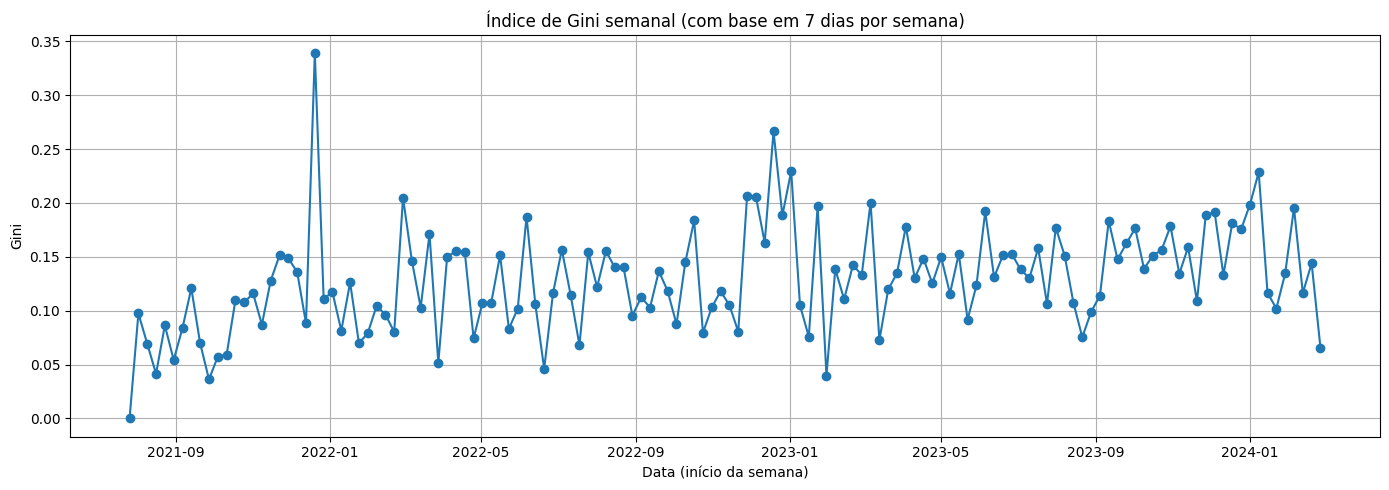

In [31]:
df_fini=gini_semanal(df_diario,coluna='count_8',plotar=True)

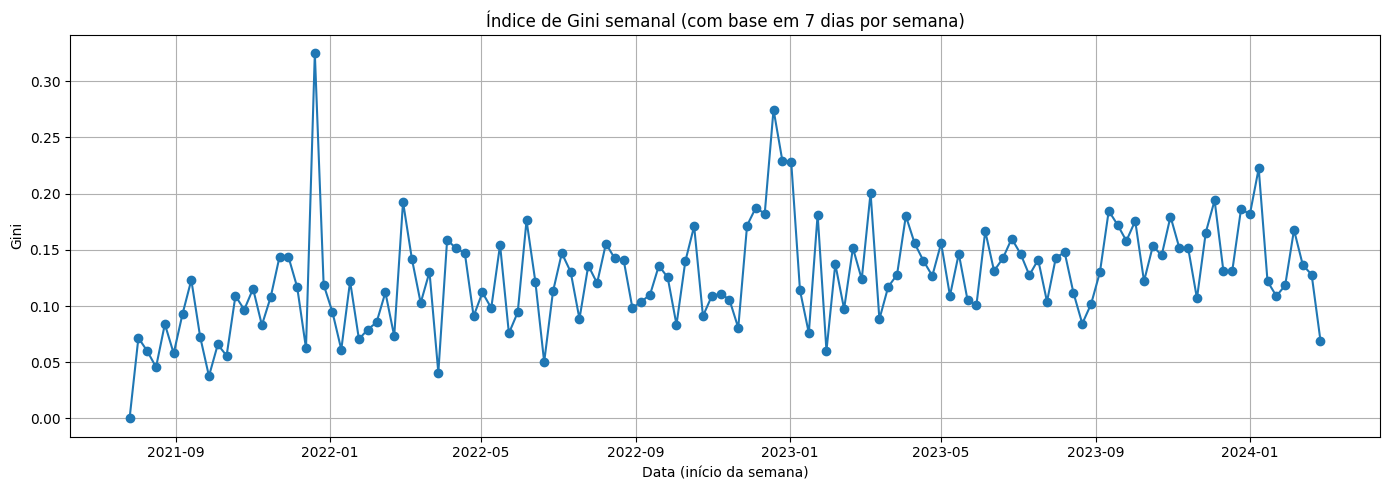

In [32]:
df_gini=gini_semanal(df_sem_tendencia,coluna='count_8',plotar=True)

In [33]:
df_diario['semana'] = df_diario['datetime'].dt.isocalendar().week
df_diario['ano'] = df_diario['datetime'].dt.isocalendar().year

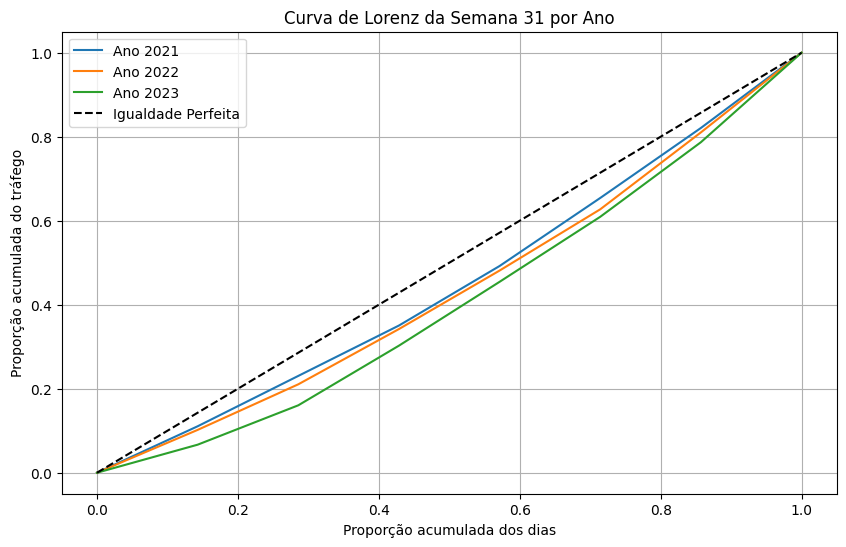

In [38]:
def curva_lorenz(valores):
    x = np.sort(np.array(valores))
    x_normalizado = x / x.sum()
    y_acumulado = np.cumsum(x_normalizado)
    y_acumulado = np.insert(y_acumulado, 0, 0)  # Começar do ponto (0,0)
    x_perc = np.linspace(0, 1, len(y_acumulado))
    return x_perc, y_acumulado

semana_escolhida = 31
anos = sorted(df_diario['ano'].unique())

plt.figure(figsize=(10, 6))

for ano in anos:
    dados = df_diario[(df_diario['ano'] == ano) & (df_diario['semana'] == semana_escolhida)]['count_8']
    if len(dados) == 0:
        continue
    x_vals, y_vals = curva_lorenz(dados)
    plt.plot(x_vals, y_vals, label=f'Ano {ano}')

plt.plot([0,1], [0,1], color='black', linestyle='--', label='Igualdade Perfeita')
plt.title(f'Curva de Lorenz da Semana {semana_escolhida} por Ano')
plt.xlabel('Proporção acumulada dos dias')
plt.ylabel('Proporção acumulada do tráfego')
plt.legend()
plt.grid(True)
plt.show()



### índice de Gini atraves da covariancia

In [35]:
def gini_covariancia(y):
    y = np.array(y)
    n = len(y)
    if n == 0 or np.sum(y) == 0:
        return np.nan

    y_sorted = np.sort(y)
    F_y = (np.arange(1, n + 1)) / n  # função de distribuição empírica (percentis)
    y_mean = np.mean(y_sorted)

    cov = np.cov(y_sorted, F_y, bias=True)[0, 1]  # covariância com bias=True para dividir por n
    gini = (2 * cov) / y_mean
    return gini

In [36]:
def gini_cov_semanal(df, coluna='count_8', plotar=True):
    # Extrair ano e semana ISO
    df['ano'] = df['datetime'].dt.isocalendar().year
    df['semana'] = df['datetime'].dt.isocalendar().week
    # Calcular o índice de Gini geométrico por grupo (ano + semana)
    df_gini_cov = (
        df.groupby(['ano', 'semana'])[coluna]
          .apply(gini_covariancia)
          .reset_index(name='gini')
    )

    # Criar uma coluna de datas para o início da semana
    df_gini_cov['semana_data'] = pd.to_datetime(
        df_gini_cov['ano'].astype(str) + '-W' + df_gini_cov['semana'].astype(str) + '-1',
        format='%G-W%V-%u',
        errors='coerce'
    )

    if plotar:
        plt.figure(figsize=(14,5))
        plt.plot(df_gini_cov['semana_data'], df_gini_cov['gini'], marker='o')
        plt.title('Índice de Gini semanal (com base em 7 dias por semana)')
        plt.xlabel('Data (início da semana)')
        plt.ylabel('Gini')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_gini_cov

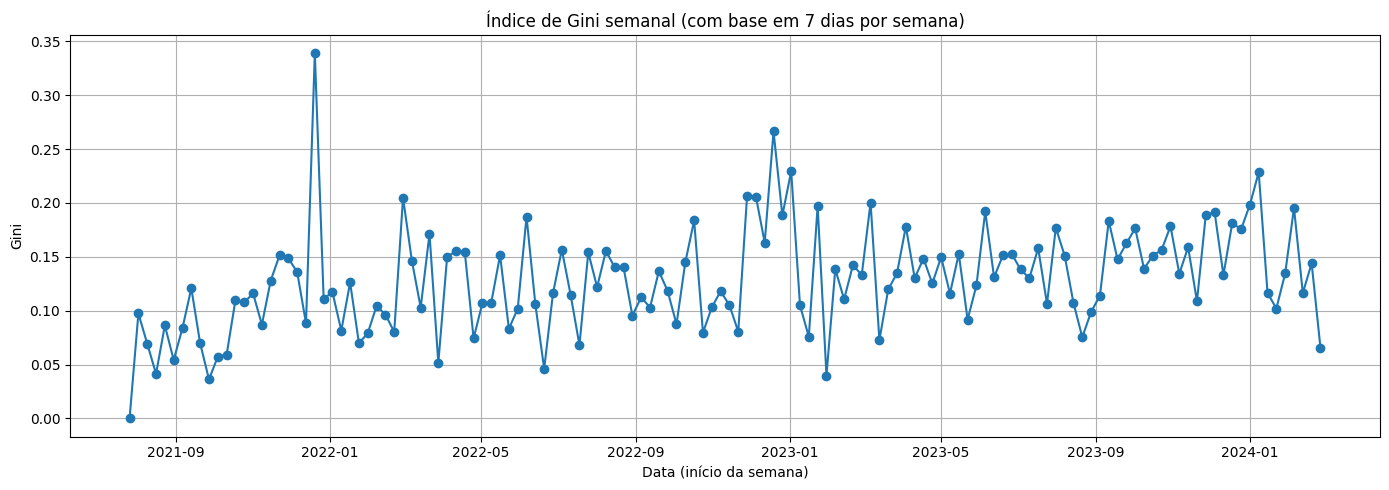

In [37]:
df_gini_cov = gini_cov_semanal(df_diario, coluna='count_8',plotar=True)

### Entropia

In [177]:
# se quizer ter semanas completas, sem começar ao domingo ou então acabar a quinta
# def entropia_semanal(df, coluna='count_8', plotar=True, data_inicio='2021-08-02', data_fim='2024-02-25'):
#     # Converter datas para datetime
#     data_inicio = pd.to_datetime(data_inicio)
#     data_fim = pd.to_datetime(data_fim)
    
#     # Filtrar o df para considerar só o intervalo desejado
#     df = df[(df['datetime'] >= data_inicio) & (df['datetime'] <= data_fim)].copy()

def entropia_semanal(df, coluna='count_8', plotar=True):
    df['ano'] = df['datetime'].dt.isocalendar().year
    df['semana'] = df['datetime'].dt.isocalendar().week

    # Função para calcular entropia 
    def calcular_entropia(x):
        x = np.array(x)
        if x.sum() == 0:
            return np.nan
        p = x / x.sum()
        return entropy(p, base=np.e)  

    # Calcular entropia semanal (por ano+semana)
    df_entropia = (
        df.groupby(['ano', 'semana'])[coluna]
          .apply(calcular_entropia)
          .reset_index(name='entropia')
    )

    # Criar coluna com data do início da semana para o eixo x no gráfico
    df_entropia['semana_data'] = pd.to_datetime(
        df_entropia['ano'].astype(str) + '-W' + df_entropia['semana'].astype(str) + '-1',
        format='%G-W%V-%u',
        errors='coerce'
    )
    
    df_entropia['T'] = np.log(7) - df_entropia['entropia']
    
    print(df_entropia)

    if plotar:
        
        plt.figure(figsize=(12, 12))
        
        plt.subplot(3, 1, 1)
        for ano in sorted(df_entropia['ano'].unique()):
            subset = df_entropia[df_entropia['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['entropia'], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
        plt.xlim(1, 53)
        plt.title('Entropia por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('Entropia')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(3, 1, 2)
        for ano in sorted(df_entropia['ano'].unique()):
            subset = df_entropia[df_entropia['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['T'], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
        plt.xlim(1, 53)
        plt.title('Theil por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('T')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


    return df_entropia


      ano  semana  entropia semana_data         T
0    2021      30  0.000000  2021-07-26  1.945910
1    2021      31  1.930693  2021-08-02  0.015218
2    2021      32  1.937876  2021-08-09  0.008034
3    2021      33  1.942680  2021-08-16  0.003230
4    2021      34  1.931840  2021-08-23  0.014070
..    ...     ...       ...         ...       ...
131  2024       5  1.911916  2024-01-29  0.033994
132  2024       6  1.874463  2024-02-05  0.071448
133  2024       7  1.924561  2024-02-12  0.021350
134  2024       8  1.909217  2024-02-19  0.036693
135  2024       9  1.378509  2024-02-26  0.567401

[136 rows x 5 columns]


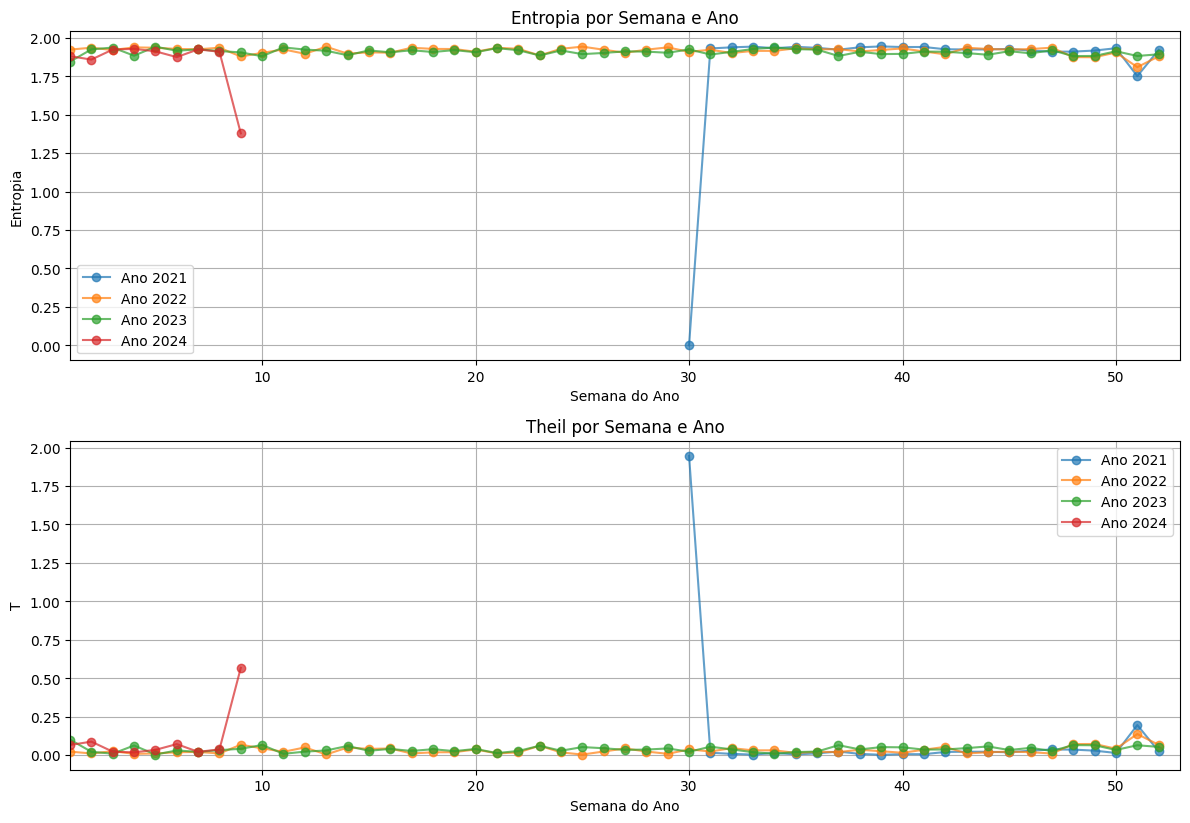

In [178]:
df_entorpia = entropia_semanal(df_diario, coluna='count_8', plotar=True )

      ano  semana  entropia semana_data         T
0    2021      30  0.000000  2021-07-26  1.945910
1    2021      31  1.937558  2021-08-02  0.008352
2    2021      32  1.940157  2021-08-09  0.005754
3    2021      33  1.941863  2021-08-16  0.004047
4    2021      34  1.931545  2021-08-23  0.014365
..    ...     ...       ...         ...       ...
131  2024       5  1.921199  2024-01-29  0.024711
132  2024       6  1.890559  2024-02-05  0.055351
133  2024       7  1.915318  2024-02-12  0.030592
134  2024       8  1.916615  2024-02-19  0.029295
135  2024       9  1.377557  2024-02-26  0.568353

[136 rows x 5 columns]


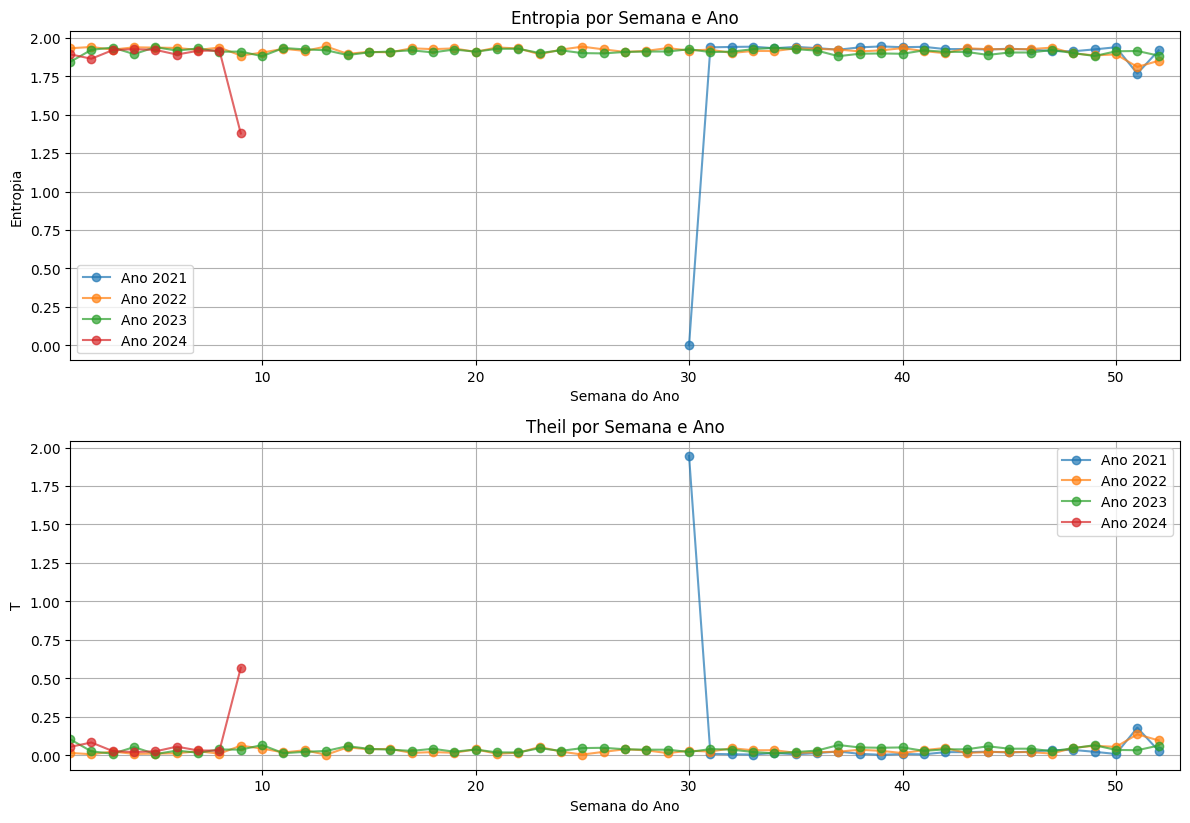

In [179]:
df_entorpia = entropia_semanal(df_sem_tendencia, coluna='count_8', plotar=True )